# Code for Simulating left-right theta sweeps in grid cells

This repository provides the code used to generate **left right theta sweeps** in grid cells.

For model details, please see:  
[Ji, Z., Chu, T., Wu, S., & Burgess, N. (2025). A systems model of alternating theta sweeps via firing rate adaptation. Current Biology, 35(4), 709-722.](https://www.sciencedirect.com/science/article/pii/S0960982224011746?via%3Dihub)

For empirical details, please see:
[Vollan, A. Z., Gardner, R. J., Moser, M. B., & Moser, E. I. (2025). Left–right-alternating theta sweeps in entorhinal–hippocampal maps of space. Nature, 639(8056), 995-1005.](https://www.nature.com/articles/s41586-024-08527-1)

---

*Created by **Zilong Ji**, UCL*

In [1]:
import numpy as np
import brainpy.math as bm

import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("..")

from sweep.network_models import DCNet, GCNet, DCParams, GCParams

from ratinabox.Environment import Environment
from ratinabox.Agent import Agent


%matplotlib inline
%load_ext autoreload
%autoreload 2

bm.set_dt(1.)  #simulation time stamp 1 ms

### generate 'real' trajectory with RatInABox (George et al, 2024, eLife)

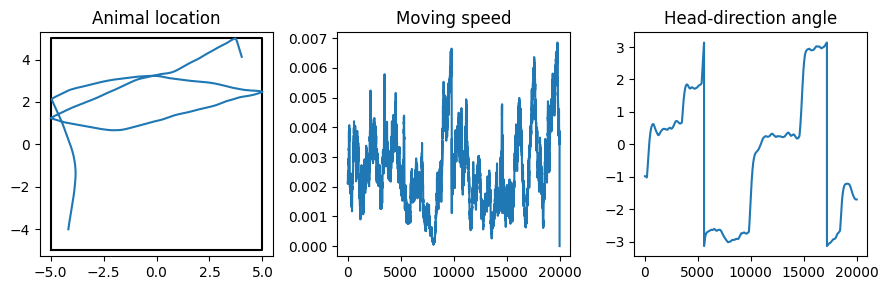

In [3]:

v0 = np.sqrt(2)*bm.pi/1000 #baseline speed
Animal_speed = 1.*v0/2 #vary this to change the speed of the animal

def generate_trajectory_withRIAB(Animal_speed, simulate_time):
    dt = 0.001 #s
    speed_mean = Animal_speed*1e3 #m/s
    rotation_velocity_std = 40*np.pi/180 #radians
    speed_std = 0. #in m/ms

    Env = Environment(params={
        "scale":2*np.pi,
        "dimensionality": "2D",
    })


    Ag = Agent(Env, params = {
        "dt": dt,
        "speed_mean":speed_mean,
        "speed_std": speed_std,
        "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
        })

    while Ag.t < simulate_time:
        Ag.update()
        
    Position = Ag.history['pos']
    HeadDirection = Ag.history['head_direction']
    # Velocity = Ag.history['vel']

    Position = np.array(Position) + x1
        # 计算相邻点之间的差分
    diff = np.diff(Position, axis=0)
    
    # 创建一个新的速度矩阵，初始值为0
    Velocity = np.zeros_like(Position)
    
    # 将差分结果赋值给速度矩阵
    Velocity[:-1, :] = diff

    # Velocity = np.array(Velocity)
    Moving_speed = np.linalg.norm(Velocity, axis=1)
    HeadDirection = np.array(HeadDirection)
    # 将 HeadDirection 转换为复数
    complex_numbers = HeadDirection[:, 0] + 1j * HeadDirection[:, 1]
    # 计算复数的幅角
    HD_angle = np.angle(complex_numbers)

    return Position, Moving_speed, HD_angle

Position, Moving_speed, HD_angle = generate_trajectory_withRIAB(Animal_speed, dur=20)

plt.show()

In [5]:
v0 = 1.0*bm.pi/1000 #baseline speed
Animal_speed = 1.0*v0 #vary this to change the speed of the animal
mbar_gc = 15. 
mabr_hd = 12.

alpha_hd = 0.4
alpha_gc = 0.6


dc_net = DCNet(cell_num=100, 
               params=DCParams(adaptation_strength=10),
               )   

gc_net = GCNet(num_dc = dc_net.cell_num,
               num_gc_x=100,
               params = GCParams(adaptation_strength=15),
               )


# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Moving_speed):  # 20 x size

    A_modulation = (2+Moving_speed/v0)/3
    theta_modulation_stre_hd = alpha_hd * 1/v0 * Moving_speed
    theta_modulation_stre_gc = alpha_gc * 1/v0 * Moving_speed

    T_theta = 100
    #calculate TheataModulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi))*A_modulation
    
    #calculate internal head direction
    dc_net.step_run(i, Head_direction, ThetaModulator_HD)
    Internal_direction = dc_net.center #center of mass of internal direction
    HD_activity = dc_net.r 

    gc_net.step_run(i, Animal_location, HD_activity, ThetaModulator_GC, Head_direction)
    
    #get results
    GC_bumpcenter = gc_net.center_position
    GC_bumpactivity = gc_net.r
    GC_bump = gc_net.gc_bump
    return GC_bumpcenter, Internal_direction, GC_bumpactivity, GC_bump, HD_activity

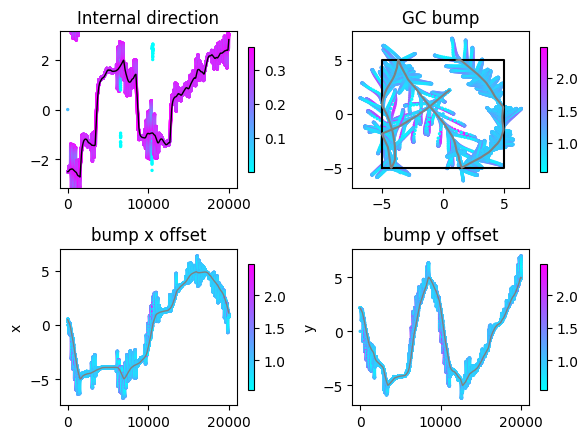

In [7]:
numT = Moving_speed.shape[0]
time_steps = np.arange(numT)
center_grid, center_HD, center_grid_input, r_grid, r_bump, r_HD = bm.for_loop(
    run_CoupleNet, (time_steps, Position, HD_angle, Moving_speed), progress_bar=True
)


start=0
end = numT
max_r_grid = np.max(r_grid, axis=1)
max_bump_activity = np.max(r_HD, axis=1)
fig, axs = plt.subplots(2, 2, figsize=(6, 4.5))
s_size = 2

ax = axs[0, 0]
ax.plot(time_steps[start:end], HD_angle[start:end], linewidth=1, color='black')

cb = ax.scatter(time_steps[start:end], 
                center_HD[start:end], 
                c=max_bump_activity[start:end], 
                cmap='cool', s=s_size)
ax.set_ylim(-bm.pi, bm.pi)
#colorbar
cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
ax.set_title('Internal direction')

ax = axs[0, 1]
ax.plot(x_bound, y_bound, 'k')
sc = ax.scatter(
                center_grid[start:end, 0],
                center_grid[start:end, 1],
                c=max_r_grid[start:end],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.plot(Position[start:end, 0], Position[start:end, 1], color="gray")
ax.set_title('GC bump')


ax = axs[1, 0]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:end], Position[start:end, 0], color='grey', linewidth=1)
ax.set_ylabel("x")
sc = ax.scatter(
                time_steps[start:end],
                center_grid[start:end, 0],
                c=max_r_grid[start:end],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump x offset')


ax = axs[1, 1]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:end], Position[start:end, 1], color='grey', linewidth=1)
ax.set_ylabel("y")
sc = ax.scatter(
                time_steps[start:end],
                center_grid[start:end, 1],
                c=max_r_grid[start:end],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump y offset')

plt.tight_layout()
plt.show()

In [14]:
np.max(data_hd[0, :])

Array(0.09457752, dtype=float32)

/tmp/ipykernel_530732/2649243495.py:73: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  red_dot.set_data(Animal_location[frame, 0], Animal_location[frame, 1])


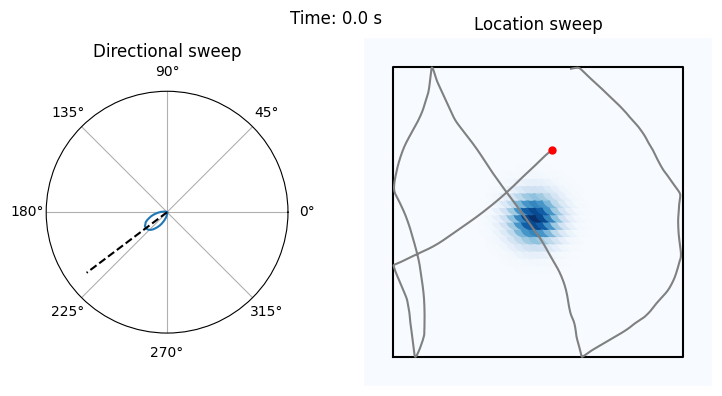

In [26]:
phi = Grid_net.value_bump
n_step = 10
Animal_location = Position[start:end:n_step,:]
HD_angle_plot = HD_angle[start:end:n_step]
R_g = r_bump[start:end, :]
data = R_g[::n_step, :]
T = data.shape[0]
beta = np.linspace(-np.pi, np.pi, 100, endpoint=False)

fig, ax_ani = plt.subplots(1, 2, figsize=(8, 4), dpi=100, width_ratios=[1, 2])

ax_hd = plt.subplot(1, 2, 1, projection='polar')

# Remove the box of subplot 2
ax_ani[0].spines['top'].set_visible(False)
ax_ani[0].spines['right'].set_visible(False)
ax_ani[0].spines['bottom'].set_visible(False)
ax_ani[0].spines['left'].set_visible(False)
# Remove the x and y ticks
ax_ani[0].set_xticks([])
ax_ani[0].set_yticks([])

# Remove the box of subplot 2
ax_ani[1].spines['top'].set_visible(False)
ax_ani[1].spines['right'].set_visible(False)
ax_ani[1].spines['bottom'].set_visible(False)
ax_ani[1].spines['left'].set_visible(False)
# Remove the x and y ticks
ax_ani[1].set_xticks([])
ax_ani[1].set_yticks([])

ax_hd = plt.subplot(1, 2, 1, projection='polar')
data_hd = r_HD[start:end:n_step, :]
# ax_hd.plot([hd_angle, hd_angle], [0, np.max(R_hd[0, :])], 'k--')
#remove y ticks
ax_hd.set_yticks([])
ax_hd.set_ylim(0., np.max(data_hd[:, :]) * 1.2)
line, = ax_hd.plot([], [])
hd_line, = ax_hd.plot([], [], 'k--')

ax_hd.set_title("Directional sweep")

ax_gc = ax_ani[1]
ax_gc.set_aspect("equal")
ax_gc.grid(True)
ax_gc.plot(x_bound, y_bound, 'k')
ax_gc.plot(Animal_location[:, 0], Animal_location[:, 1], color="gray")

# # Add text to the middle of ax_ani[0, 0]
time_text = ax_hd.text(1.2, 1.3, '', transform=ax_hd.transAxes, ha='center', va='center', fontsize=12)

vmin1 = 0
vmax1 = np.max(data)
scatter1 = ax_gc.scatter([], [], c=[], s=200, cmap="Blues", vmin=vmin1, vmax=vmax1)
ax_gc.set_title("Location sweep")
red_dot, = ax_gc.plot([], [], 'ro', markersize=5)
trajectory, = ax.plot([], [], color='#F18D00', linestyle='-', linewidth=1.5)
ax_gc.set_xlim(x1-1, x2+1)
ax_gc.set_ylim(x1-1, x2+1)
bump_centers = []

def update(frame):
    y_hd = data_hd[frame].flatten()
    line.set_data(beta, y_hd)
    
    hd_line.set_data([HD_angle_plot[frame], HD_angle_plot[frame]], [0, np.max(data_hd[:, :])])
    
    time_text.set_text(f"Time: {frame / 100:.1f} s")
    
    y1 = data[frame].flatten()
    scatter1.set_offsets(np.column_stack((phi[:, 0], phi[:, 1])))
    scatter1.set_array(y1)
    red_dot.set_data(Animal_location[frame, 0], Animal_location[frame, 1])
    bump_center_idx = np.argmax(y1)
    bump_center = phi[bump_center_idx, :]
    bump_centers.append(bump_center)
    trajectory.set_data(np.array(bump_centers)[:, 0], np.array(bump_centers)[:, 1])
    return scatter1

ani = FuncAnimation(fig, update, frames=T, interval=100, blit=False)
plt.tight_layout()

ani.save("./Animations/Sweeps_on_real_trajectory.mp4", writer="ffmpeg", fps=10)

In [ ]:
T